<a href="https://colab.research.google.com/github/ljsonnanburg/Classifying-Fake-News/blob/main/Classifying_Fake_News.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

#for text processing
import re, string
import nltk
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from wordcloud import WordCloud,STOPWORDS

#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc, roc_auc_score
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split

# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import decomposition, ensemble
#for word embedding
#import gensim

# to avoid needing to re-run code
import pickle
import os

# for visualizations
import seaborn as sns 
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import GridSearchCV
import plotly.graph_objects as go

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


# Introduction
False or misleading information being spread either to promote a certain agenda or use sensationalist messaging to sell news media is nothing new. Outright propaganda designed to sway public opinion about how a war is going or whether a public figure is incompetent or some kind of divine incarnation may predate the printing press by more than a thousand years. Tabloid journalism goes back at least as far as 1770, with London publications that effectively collected protection money from socialites and nobility to avoid having gossip printed about them. 

However, more recent advances in technology have led to significantly increased discussion of "fake news"--mass media communication make it easy to spread these messages through various avenues with no or low cost of entry, while social media allows the public to instantly react to or share these stories. If you're on Twitter, Facebook, or another platform, odds are you'll occasionally see intentionally or unintentionally misleading information or linked articles in your feed. It could be on your screen because its attention-grabbing title is driving engagement and promoting its visibility by an algorithm that wants more and more users clicking on more and more things... or it could be because your friend shared it because they found it outraging and didn't have or want to take the free time to vet it for accuracy. 

So, how can we know what to trust when it's so much easier to spread information than it is to verify that it's correct?

### Problem Statement

Given pre-labeled "real" and "fake" news items to train on, can we design a model that accurately predicts whether future articles are true, valuable content or some form of clickbait or propaganda? 

# Data Preparation


In [2]:
# Loading data for true news items
true_news = pd.read_csv("https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectFN/data/true.csv")
true_news['veracity'] = 'real' # identifying these news items as real
# Loading data for fake news items
fake_news = pd.read_csv("https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectFN/data/fake.csv")
fake_news['veracity'] = 'fake' # identifying these news items as fake
df = [true_news + fake_news]
df = pd.concat([true_news, fake_news]).reset_index(drop = True) # Vertical concatenation of real/fake news
#df['corpus'] = df['title'] + ' ' + df['text'] 
print(df.info())
print(df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     44898 non-null  object
 1   text      44898 non-null  object
 2   subject   44898 non-null  object
 3   date      44898 non-null  object
 4   veracity  44898 non-null  object
dtypes: object(5)
memory usage: 1.7+ MB
None
title       0
text        0
subject     0
date        0
veracity    0
dtype: int64


Here we see there is no missing data, and all data is string objects.

In [3]:
df.sample(5) # Sample of real/fake news items

,title,text,subject,date,veracity
2839,FBI director nominee Wray earned $9.2 million ...,WASHINGTON (Reuters) - President Donald Trump’...,politicsNews,"July 10, 2017",real
29248,Bill Maher Acts Out Trump SOTU Address And PE...,Imagining what Donald Trump would be like as t...,News,"February 27, 2016",fake
36121,BREAKING: Iran Publicly Humiliates Obama…Unvei...,A clear violation of Obama s lopsided deal w...,politics,"Jan 5, 2016",fake
2045,Trump warns may terminate NAFTA treaty,PHOENIX (Reuters) - U.S. President Donald Trum...,politicsNews,"August 23, 2017",real
2314,"In blustery call, Trump pressured Mexico on bo...",WASHINGTON (Reuters) - President Donald Trump ...,politicsNews,"August 3, 2017",real


The given variable names are self-explanatory;
* title, the article's title,
* text, the body text of the article,
* subject, the topic discussed in the article,
* date, the date the article was published,
* veractiy, whether or not an article is "real" or "fake" depending on the dataset it came from. 

## Data Cleansing
There are no missing values, but it still remains to check that the records make sense. First: articles typically conform to at least basic grammar rules, and should mostly begin with capitalized letters. Here, checking for the first letter being lowercase reveals a handful of junk items that likely made their way into the fake news dataset as a mistake.


In [4]:
print(df[df['title'].str[0].str.islower()])
df[df['title'].str.contains('http')]

                                                   title  ... veracity
30775  https://100percentfedup.com/served-roy-moore-v...  ...     fake
36615  jeb! Bush Has Discovered The Secret To What Am...  ...     fake
36924  https://100percentfedup.com/video-hillary-aske...  ...     fake
36925  https://100percentfedup.com/12-yr-old-black-co...  ...     fake
37256  https://fedup.wpengine.com/wp-content/uploads/...  ...     fake
37257  https://fedup.wpengine.com/wp-content/uploads/...  ...     fake
38849  https://fedup.wpengine.com/wp-content/uploads/...  ...     fake
38850  https://fedup.wpengine.com/wp-content/uploads/...  ...     fake
43286  https://fedup.wpengine.com/wp-content/uploads/...  ...     fake
43287  https://fedup.wpengine.com/wp-content/uploads/...  ...     fake

[10 rows x 5 columns]


,title,text,subject,date,veracity
30775,https://100percentfedup.com/served-roy-moore-v...,https://100percentfedup.com/served-roy-moore-v...,politics,https://100percentfedup.com/served-roy-moore-v...,fake
36924,https://100percentfedup.com/video-hillary-aske...,https://100percentfedup.com/video-hillary-aske...,politics,https://100percentfedup.com/video-hillary-aske...,fake
36925,https://100percentfedup.com/12-yr-old-black-co...,https://100percentfedup.com/12-yr-old-black-co...,politics,https://100percentfedup.com/12-yr-old-black-co...,fake
37256,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,politics,https://fedup.wpengine.com/wp-content/uploads/...,fake
37257,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,politics,https://fedup.wpengine.com/wp-content/uploads/...,fake
38849,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,Government News,https://fedup.wpengine.com/wp-content/uploads/...,fake
38850,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,Government News,https://fedup.wpengine.com/wp-content/uploads/...,fake
43286,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,left-news,https://fedup.wpengine.com/wp-content/uploads/...,fake
43287,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,left-news,https://fedup.wpengine.com/wp-content/uploads/...,fake


In [5]:
df = df[~df['title'].str.contains('http')] # Dropping junk rows with URLS for text

In order to do any kind of time series analysis, we need valid dates associated with these articles.

In [6]:
# Finds rows with invalid dates
not_datetime = pd.to_datetime(df['date'], errors='coerce').isna()

df['baddate'] = not_datetime
df[df['baddate'] == True]

,title,text,subject,date,veracity,baddate
40350,Homepage,[vc_row][vc_column width= 1/1 ][td_block_trend...,left-news,MSNBC HOST Rudely Assumes Steel Worker Would N...,fake,True


There's only one remaining, and it appears to be more junk data. We can drop it, and then convert the remaining date values to datetime objects. After that, our new baddate variable is no longer useful and can be removed.

In [7]:
df = df[~df['baddate'] == True]
df['date'] = pd.to_datetime(df['date'])
df.drop(['baddate'], axis=1, inplace=True)

For remaining rows, we create a corpus for each row made up of both the title and article body. Text case is normalized, punctuation is stripped away, and stop words that contribute no meaning individually are removed.

In [8]:
# Function to begin cleaning up text
stopwords = nltk.corpus.stopwords.words('english')
# Avoids later stemming "U.S." to "u" and taking links to videos as text
df['corpus'] = df['title'] + ' ' + df['text'] 
def clean_text(text):
    #text = pattern.sub(lambda m: replacements[re.escape(m.group(0))], text)
    text = text.replace('U.S.', 'united states') # avoids later processing reducing frequent "U.S." from turning into "u"
    # handles instances where links to videos or polls are included in article titles
    text = text.replace('[VIDEO]', '')
    text = text.replace('(VIDEO)', '')
    text = text.replace('[POLL]', '')
    text = text.replace('(POLL)', '')
    text = text.translate(str.maketrans('', '', string.punctuation)) # removes punctuation
    text = text.lower() # puts all text into lowercase
    text = ' '.join([word for word in text.split() if word not in (stopwords)])
    return text

### Stemming

For the important TF-IDF vectorization, I want to have items stemmed to their root words. This way, instances of terms such as "care" and "caring" should be counted as the same variable.

In [9]:
df.reset_index()
try:
  stemmed = pickle.load(open('stemmed.pkl', 'rb'))
except:
  snow_stemmer = SnowballStemmer(language='english')
  stemmed = []
  for i in range(0, len(df)):
      try:
        item = df['corpus'][i].split()
        item = [snow_stemmer.stem(word) for word in item]
        item = ' '.join(item)
        stemmed.append(item)  
      # Excludes a few rows where this stemmer fails;  
      except:
        stemmed.append('')
df['stemmed'] = stemmed

In [10]:
clean_df = df.copy()
df['corpus'] = df['corpus'].apply(lambda x:clean_text(x))
df.sample(5)

,title,text,subject,date,veracity,corpus,stemmed
43522,Boiler Room EP #110 – A Deeper Game: Masters o...,Tune in to the Alternate Current Radio Network...,US_News,2017-05-26,fake,boiler room ep 110 – deeper game masters chaos...,is the unit state of america a liber democracy...
16652,Former Finance Minister Schaeuble elected to h...,BERLIN (Reuters) - Former German Finance Minis...,worldnews,2017-10-24,real,former finance minister schaeuble elected head...,former financ minist schaeubl elect to head ge...
41706,BREAKING: FELON WEARING BLACK LIVES MATTER T-S...,Obama s war against cops and white people in f...,left-news,2016-07-12,fake,breaking felon wearing black lives matter tshi...,how hillari anti-cop past and support for viol...
12929,U.S. officials warn of ISIS' new caliphate: cy...,WASHINGTON (Reuters) - The collapse of Islamic...,worldnews,2017-12-06,real,united states officials warn isis new caliphat...,u.s. offici warn of isi new caliphate: cybersp...
44639,‘Anti-Russia’ Escalation? Plans for New US Mar...,21st Century Wire says It seems that US anti-R...,Middle-east,2016-10-19,fake,‘antirussia’ escalation plans new us marine ba...,exclusive: ex-berni deleg reveal whi he fled d...


# Data Exploration and Visualizations

In [11]:
# Graphs the subjects that show up in each dataframe; there is no overlap in subjects as given
fig = px.histogram(df, x='subject', color='veracity', title='Number of Articles per Subject Matter')
fig.update_layout(barmode='group')
fig.show()

In [12]:
# Printing unique names from each dataframe to confirm there is no overlap
print(df.loc[df['veracity'] == 'real']['subject'].unique())
print(df.loc[df['veracity'] == 'fake']['subject'].unique())

['politicsNews' 'worldnews']
['News' 'politics' 'Government News' 'left-news' 'US_News' 'Middle-east']


We see that any given subject is entirely sorted into either real or fake news with absolutely no overlap. To compare these in a reasonable way, we would need to rename categories of the "subject" feature to match. Certain steps to this seem obvious: "politicsNews" from true_news likely has overlap with "politics" and possibly "left-news" from fake_news.

...While other steps do not: There is no third category for apolitical local news in true_df; would news about the home government be world news or political news or a third category that still does not exist in true_df?

Since any recategorization would be at least somewhat arbitrary and result in a feature with only two levels, this is ignored to avoid overweighting what could be incorrect guesses.


## Word Counts for News Items

In [13]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(1, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

### Real News Item Word Cloud

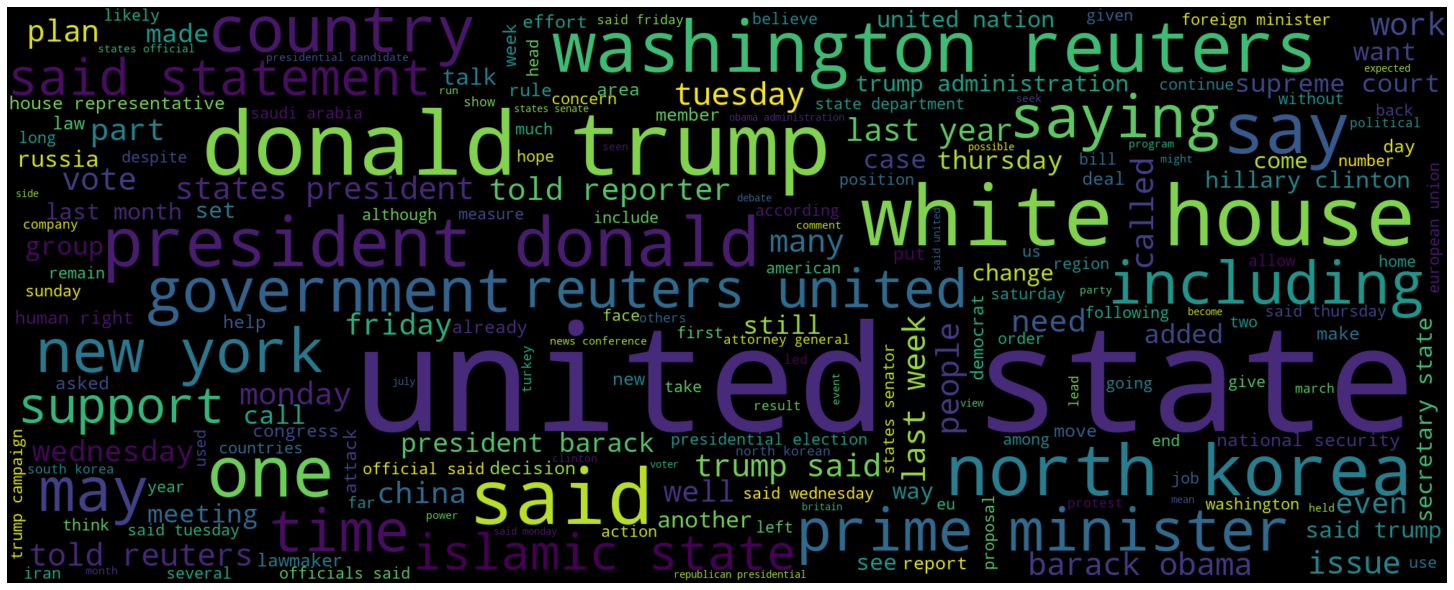

In [36]:
text = ' '.join(df.loc[df['veracity'] == 'real']['corpus'])
wordcloud = WordCloud(
    width = 2000,
    height = 800,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
plt.figure(figsize = (20, 12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [15]:
text = ' '.join(df.loc[df['veracity'] == 'real']['corpus'])
common_words = get_top_n_trigram(df.loc[df['veracity'] == 'real']['corpus'], 50)
word_df = pd.DataFrame(common_words, columns = ['words' , 'count'])
fig = px.bar(word_df, x='words', y= 'count')
fig.update_xaxes(tickangle=320)
fig.update_layout(title='ngrams of length 1-3 in real news items, ranked by frequency ')
fig.show()

*   "Said" being the most common word (and "told" being high in the ranking) could be related to accurate reporting relying on direct quotes
*   The most frequent subjects of true news items appear to be the United States and Donald Trump, suggesting this data set is U.S.-focused
*   Several appearances of Reuters suggest that a lot of true news items come directly from Reuters outlets, or other outlets sourcing Reuters reporting
*   Terms unambiguously specifying the timing of events (e.g., "said wednesday", "last month", "first") appear very frequently in true news items
*   Words with direct positive or negative connotations are not frequent



### Word Cloud for Fake News Items

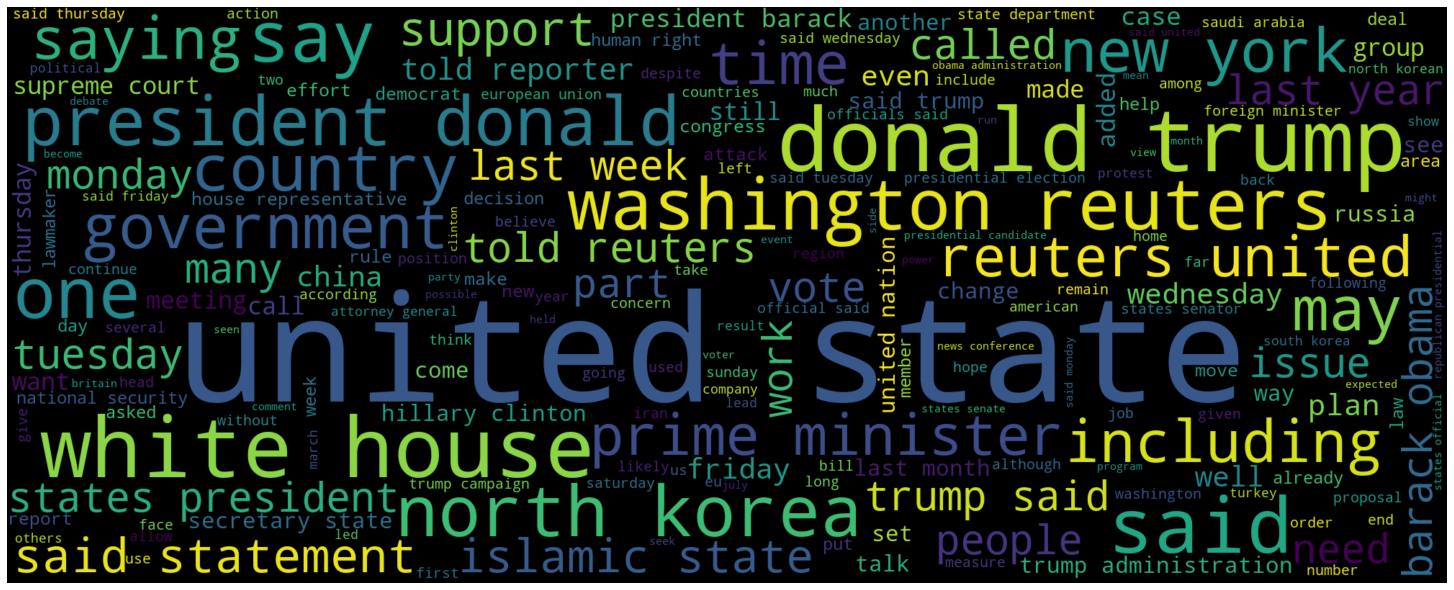

In [35]:
wordcloud = WordCloud(
    width = 2000,
    height = 800,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
plt.figure(figsize = (20, 12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [17]:
common_words = get_top_n_trigram(df.loc[df['veracity'] == 'fake']['corpus'], 50)
word_df = pd.DataFrame(common_words, columns = ['words' , 'count'])
fig = px.bar(word_df, x='words', y= 'count')
fig.update_xaxes(tickangle=320)
fig.update_layout(title='ngrams of length 1-3 in fake news items, ranked by frequency ')
fig.show()

*   The counts of "said" and "told" could imply that fake new articles only use direct quotes a third as often.
*   Donald Trump is far and away the most frequent topic of discussion, while other prominent figures also rank higher than before
*   Instances of terms like "supporter", "student", and "person" suggest many of the fake news items might focus on subjects that are not traditionally news-worthy
*   Terms like "according", "tweet", "interview", "comment", "video", and "image via" suggest higher frequency of second-hand reporting
*   Terms with loaded connotations like "lie", "fake", "attack", and "problem" may point to more opinionated writing

### Veracity Over Time

In [18]:
fake = df[df['veracity'] == 'fake'].groupby(['date'])['title'].count()
real = df[df['veracity'] == 'real'].groupby(['date'])['title'].count()

fig = go.Figure()
fig.add_trace(go.Scatter(
    name='Fake News',
    mode='lines', x=fake.index, y=fake.values
))
fig.add_trace(go.Scatter(
    name='Real News',
    mode='lines', x=real.index, y=real.values
))
fig.update_layout(title_text='Occurrence of Real and Fake News Items Over Time')
fig.show()

This graph plots the number of real or fake news items in the data on any given day. There are a few obvious observations to be made:
* The data for fake news is collected from a longer span of time. 

# Feature Engineering

### Sensationalist/Clickbait Titles
If we look at the titles of these articles...

In [34]:
pd.set_option("max_colwidth", 400)
display(df[['title','veracity']].sample(10, random_state=0))
pd.reset_option("max_colwidth")

,title,veracity
8222,U.S. House Speaker Ryan: Pacific trade deal faces defeat in Congress,real
18376,Spain's high court calls head of Catalan police to testify,real
14482,Australian medical group wants access to Manus Island asylum seekers,real
24333,Trump Delivers First Embarrassing Spelling Error Of His Presidency And Gets HUMILIATED By Twitter,fake
18018,Israel strikes Hamas post after Gaza rocket fire,real
29729,Watch Chris Christie Admit To Rachel Maddow’s Face That He’s Terrified Of Her (VIDEO),fake
9020,Medicare program spending within target rate: trustees,real
2988,Trump to nominate Textron executive for Pentagon acquisition post,real
24567,Trump Sabotages His Own Call For Unity By Calling Democratic Leader A ‘Clown’,fake
24158,"Reuters News Agency Declares War On Trump In The Most PERFECT Way, Trump HUMILIATED",fake


A few patterns are apparent.
*   Fake news items have a lot of vague, attention-grabbing titles that sound outrageous, but convey very little concrete information
*   Promises of a link to a "(VIDEO)" may be common in fake news items
*   Fake news items have A LOT OF WORDS in all-caps, while true ones appear to have none

Intelligent screening for "click-baity" attention grabbing headlines would be a difficult task beyond the scope of this project.

In [20]:
# Checking if "VIDEO" ever appears in true news items
df[df['title'].str.contains('VIDEO')]['veracity'].unique() 

array(['fake'], dtype=object)

The fact that "VIDEO" only appears in fake news items makes it a very effective predictor of whether an article is true or false. While this isn't useless information, it isn't helpful in categorizing titles that do *not* contain "VIDEO". This is why instances of "[VIDEO]" and "(VIDEO)" were previously omitted from the corpus.


The occurrence of all-caps words, on the other hand, is a time-honored tradition in tabloid journalism and may yield interesting results, here.

In [21]:
# Function checking for the frequency of words that are in all-caps
def check_all_caps(text):
  text = text.translate(str.maketrans('', '', string.punctuation))
  text = text.split()
  caps_count = 0
  for word in text:
    if(word == word.upper()):
      caps_count += 1
  return caps_count/len(text)

In [22]:
df['caps'] = df['title'].apply(check_all_caps)
pd.set_option("max_colwidth", 400)
display(df[['title','veracity','caps']].sample(25))
pd.reset_option("max_colwidth")

,title,veracity,caps
26051,NYPD So Delighted With Cop Who Killed Eric Garner They Now Pay Him $120K,fake,0.142857
21608,"Trump Wets His Pants Over Bob Corker Again, Corker Alerts The White House Daycare Staff",fake,0.000000
2256,Bush-era FTC official is Trump favorite for chief: source,real,0.111111
16390,Finland wants EU to give up daylight saving time,real,0.111111
40628,#Berkeley CRAZY! RIOTERS CHASE And Beat People Shouting: “Beat his ass!” [Video],fake,0.250000
36286,Deja Vu: Hillary Wants $275 Billion For Shovel-Ready Union Jobs,fake,0.100000
4426,U.S. Commerce chief says EXIM Bank part of Trump 'trade toolbox',real,0.181818
16626,Dutchman put on trial for Ethiopian war crimes in 1970s,real,0.000000
38793,OBAMACARE TAKING DOWN MORE RURAL HOSPITALS,fake,1.000000
37894,BUSTED! OBAMA AND HILLARY LIED: Former Hostage Reveals Proof The $400 Million Dollars Was Ransom Given To Iran [Video],fake,0.315789


In [23]:
fig = px.box(df, y='caps', color = 'veracity', title='Box plot showing distribution of fully capitalized words in article titles')
fig.update_layout(barmode='group')
fig.show()

Visually, the difference appears significant, and we will confirm with hypothesis testing. Because we lack knowledge of data beyond this data set, we can play it safe with a quick Student's T-test with the null hypothesis that the mean of all-capitalized words in real and fake news items is roughly the same.

In [24]:
a = df.loc[df['veracity'] == 'real']['caps']
b = df.loc[df['veracity'] == 'fake']['caps']
stats.ttest_ind(a,b, equal_var=False)

Ttest_indResult(statistic=-132.25312163508994, pvalue=0.0)

With an infinitismal p-value, we can reject the null hypothesis. As expected, there is a statistically significant difference in how much real and fake news items use all-caps text in their titles. However, as with the use of "VIDEO" in titles, these results are incredibly lopsided and easy to interpret. We do not need sophisticated tools for a program (or user) to flag "(VIDEO)" or FULLY CAPITALIZED TITLES as suspicious. While it would almost certainly make our model more accurate to incorporate this finding, it could also devalue more subtle patterns in the data. 



### TF-IDF
A TF-IDF score for a given word and article indicates the frequency of that word showing up in that article, relative to how often it shows up in the corpus as a whole. 

The relevance in this study is: if a given term shows up frequently in real articles and not often in the fake articles, its TF-IDF score among real articles will be higher. Then, future articles featuring that term will be considered more likely to be real. Greater concentrations of these real-leaning terms make an article more likely to be classified as real, and the same would be true with fake-leaning terms leading to fake classifications.

In this implementation, the terms being considered are the top 10,000 ngrams made up of between 1 and 4 words. 4 was chosen as an upper bound to potentially capture combinations of the common bigrams from the word clouds.

In [25]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['veracity','title','text','subject','date'], axis=1), df['veracity'])

In [26]:
tfidf_vectorizer = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000,ngram_range=(1,4))

In [27]:
try:
  X_train_tfidf = pickle.load(open('X_train_tfidf.pkl', 'rb'))
  X_test_tfidf = pickle.load(open('X_test_tfidf.pkl', 'rb'))
except:
  tfidf_vectorizer.fit(df['stemmed'])
  X_train_tfidf =  tfidf_vectorizer.transform(X_train['stemmed'])
  X_test_tfidf =  tfidf_vectorizer.transform(X_test['stemmed'])
  output = open('X_train_tfidf', 'wb')
  pickle.dump(X_train_tfidf, output)
  output = open('X_test_tfidf', 'wb')
  pickle.dump(X_test_tfidf, output)

# Model Selection
In order to accurately classify articles, several statistical models are compared. 

The comparison process is to use a pipeline attempting fits and predictions for several models, with a gridsearch function using multiple hyperparameters for each one. The chosen model has the highest accuracy.

With a clear need to catch more fake news stories or verify more true news stories, precision or recall could be switched in as a scoring mechanism, instead.

In [28]:
try:
  grid = pickle.load(open('grid.pkl', 'rb'))
except: 
  pipe = Pipeline(steps=[('estimator', LinearSVC())])
  params_grid = [{'estimator':[MultinomialNB()],
                'estimator__alpha':[1,.1,.01]
                },
               {'estimator':[RandomForestClassifier()],
                'estimator__max_features':['auto','sqrt','log2'],
                'estimator__bootstrap': [True, False],
                'estimator__n_jobs':[5],
                'estimator__random_state': [0]
                },
               {
                'estimator':[LinearSVC()],
                'estimator__C': [1, 10, 100],
                'estimator__loss': ['hinge', 'squared_hinge'],
                'estimator__max_iter': [10000],
                'estimator__random_state': [0]
                },
               
              ]
  grid = GridSearchCV(pipe, params_grid)
  grid.fit(X_train_tfidf,y_train)
  output = open('grid', 'wb')
  pickle.dump(grid, output)

print(grid.best_params_)
print(grid.best_score_)

{'estimator': RandomForestClassifier(bootstrap=False, n_jobs=5, random_state=0), 'estimator__bootstrap': False, 'estimator__max_features': 'auto', 'estimator__n_jobs': 5, 'estimator__random_state': 0}
0.9989009621565688


The winning model is a random forest classifier, evaluated in more detail below.

In [29]:
def evaluate_model(clf, y_true, y_pred):
  print(classification_report(y_true, y_pred, target_names=['False','True']))
  cm = confusion_matrix(y_true, y_pred, labels=clf.classes_)
  
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=clf.classes_)
  fig, ax = plt.subplots(figsize=(10,10))
  disp.plot(ax=ax)#, cmap='RdBu') 

In [30]:
good_model = RandomForestClassifier(n_jobs=5, bootstrap=True,max_features='auto', max_depth=5)
good_model.fit(X_train_tfidf, y_train)
y_pred=good_model.predict(X_test_tfidf)

              precision    recall  f1-score   support

       False       0.99      0.99      0.99      5905
        True       0.99      0.99      0.99      5317

    accuracy                           0.99     11222
   macro avg       0.99      0.99      0.99     11222
weighted avg       0.99      0.99      0.99     11222



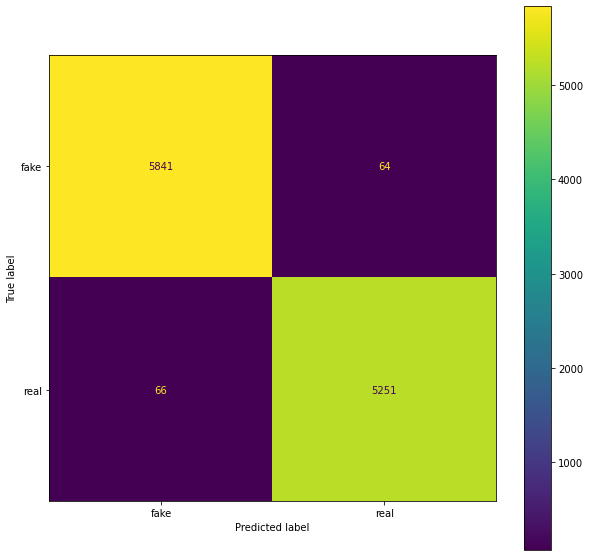

In [31]:
evaluate_model(good_model, y_test, y_pred)

Below are some of the most influential stemmed terms that have the biggest impact on evaluating a news item as real or fake.

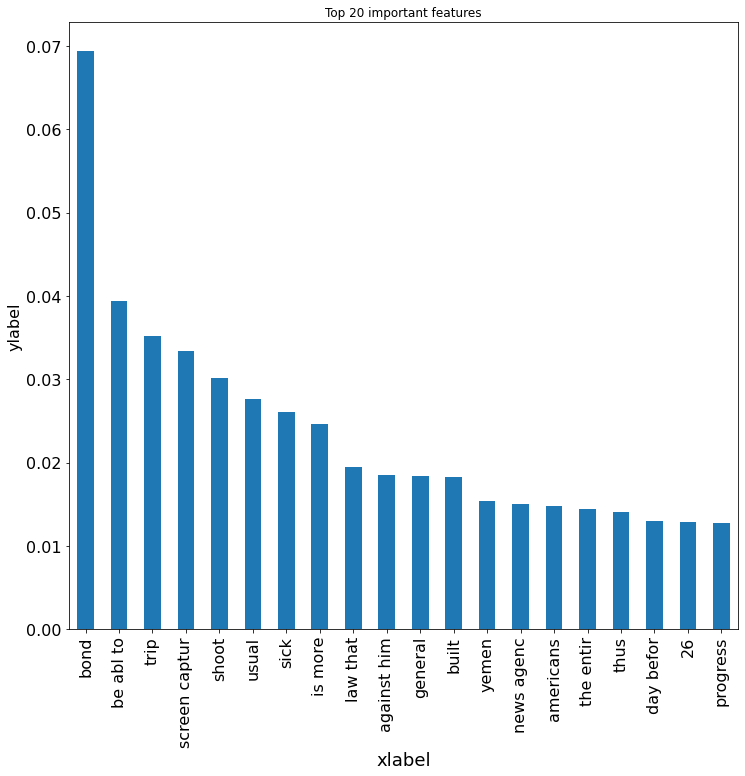

In [32]:
feat_importances = pd.Series(good_model.feature_importances_, index=tfidf_vectorizer.vocabulary_)
feat_importances.nlargest(20).plot(kind='bar',figsize=(10,10))
plt.title("Top 20 important features")
plt.tight_layout()
plt.rc('axes', titlesize=16) 
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=16)
plt.xticks(fontsize= 16)
plt.yticks(fontsize= 16)
plt.show()

While some of this is confusing, some of it is interesting. For brevity, the full text of articles exemplifying these will not be repeated here, so I'll ask that you trust this appraisal:

"Crazi", "disgrac", and "nazi" seem to mostly come from fake-tagged articles littered with insults. 

Names of highly politicized figures in U.S. media (most prominently here Colin kaepernick and Michelle Obama) appear very frequently in fake articles. While "Suu" (Aung San Suu Kyi) is much further removed from U.S. politics and is primarily mentioned in "real"-tagged news articles. 



In [33]:
y_test_remap = y_test.replace(['fake','real'],[0,1])

y_score = good_model.predict_proba(X_test_tfidf)[:,1]
fpr, tpr, thresholds = roc_curve(y_test_remap,y_score)

# Evaluating model performance at various thresholds
roc = pd.DataFrame({
    'False Positive Rate': fpr,
    'True Positive Rate': tpr
}, index=thresholds)
roc.index.name = "Thresholds"
roc.columns.name = "Rate"



fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()

# Conclusion
It is worth keeping in mind that a supervised learning model detecting deceit will always have the shortcoming of needing to assume that the party that labeled these articles did so accurately and without bias. However, if we accept that assumption, the resulting model predicts it *very well*, and there is little room for improvement without additional data. The other shortcoming of this model is that it is trained on a specific subset of news outlets that may be entirely U.S.-based, and certain elements may not generalize well to global news sources.

That aside, the accuracy confirms great predictive power, and the concept is sound. The answer to the question of whether we *can* predict the veracity of news items is a clear and resounding "yes".

If one trusts the original labelers and wants to quickly identify real or fake news items at a glance without feeding them through this model, there are some apparent patterns:


*   News sourced from Reuters tends to be reliable
*   Articles with direct quotes and specifying language about times and locations are more likely to be real
*   The more words in an article that are capitalized, the more likely the article is to be fake 
*   If the article frequently uses pointed, judgmental language, it may be less than factual
*   If the article frequently name drops controversial figures, it... well, it could go either way, really, try running it through the model











The real shortcomings of this investigation stem not from the models, but the data and lacking contextual information. A support vector machine model was able to nearly match these results with no fine-tuning, which suggests this data is surprisingly linearly separable for a large mass of text; in other words, this appears to simply be an easy problem. This data also appears to come primarily or perhaps entirely from web-based U.S. publications. These findings might not generalize to more global news outlets. Also, a supervised learning approach to classifying dishonesty will always have the inherent flaw of needing to trust whatever source assigned the labels we train a model on.

Still, the model is clearly identifying some definite patterns to be this accurate, and a sample of "fake news" articles do appear to be just that. In this particular dataset, the answer to the question "can we make an effective classifier fo real and fake news?" seems to be a clear, resounding yes. 